### LSTM

In [1]:
# importer
import yfinance as yfin
import torch
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import sys
import os
sys.path.append(os.path.abspath(".."))
from torch.nn import Module, Linear, MSELoss
from torch.nn import LSTM as torch_LSTM
from torch.optim import Adam
from ml_utils import parse_config, vizualization
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection  import train_test_split

In [3]:
VALID_JSON={
    "data":
    {
        "type":"object",
        "properties":
        {
            "ticker":
            {
                "type":"string"
            },
            "start_date":
            {
                "type":int
            },
            "end_date":
            {
                "type":int
            }
        },
        "required":["ticker", "start_date", "end_date"]
    },
    "hpr_prm":
    {
        "type":"object",
        "properties":
        {
            "lr":
            {
                "type":"number",
                "minimum":0.000001,
                "maximum":1.0
            },
            "hidden_size":
            {
                "type":"number"
            },
            "num_layers":
            {
                "type":"number"
            },
            "epochs":
            {
                "type":"integer"
            },
            "seq_len":
            {
                "type":"integer"
            }
        },
        "required":["epochs", "lr", "hidden_size", "num_layers","seq_len"]
    },
    "opt":
    {
        "type":"object",
        "properties":
        {
            "viz_stp":
            {
                "type":"integer"
            }
        },
        "required":["viz_stp"]
    },
    "required":["data", "hpr_prm", "opt"]
}

In [4]:
class LSTM(Module):
    def __init__(self, input_size:int, hidden_size:int, output_size:int, num_layers:int, device):
        super().__init__()
        self.device = device
        self.num_layers = num_layers
        self.hidden_size = hidden_size
        self.lstm = torch_LSTM(input_size, hidden_size, num_layers, batch_first=True)
        self.fc = Linear(hidden_size, output_size)

    def forward(self, x):
        h0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size).to(self.device)
        c0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size).to(self.device)
        out, _ = self.lstm(x, (h0,c0))
        out = self.fc(out[:, -1, :])
        return out

In [5]:
def create_data(ticker:str, start_date:str, end_date:str):
    df = yfin.download(ticker, start_date, end_date)
    return df['Close'].values.reshape(-1, 1)

def create_dataset(data:np.ndarray, seq_len:int):
    X = []
    y = []
    for i in range(len(data)-seq_len):
        X.append(data[i:i+seq_len])
        y.append(data[i+seq_len])
    return np.array(X), np.array(y)


In [7]:
def train(model:Module, X_train:torch.tensor, y_train:torch.tensor, criterion:MSELoss, optimizer:Adam, epochs:int, viz_stp:int, ticker:str):
    x_epoch = np.arange(0, epochs)
    y_loss = np.zeros(epochs)

    model.train()
    for epoch in range(epochs):
        output = model(X_train)
        loss = criterion(output, y_train)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        y_loss[epoch] = loss.item()
        if epoch % viz_stp == 0:
            print(f'Epoch [{epoch}/{epochs}] finished with loss: {y_loss[epoch]}')
        
    
    vizualization(x_epoch, 'Epochs', y_loss, 'Loss', f'Loss over epochs by price on stock {ticker}')


def test(model:Module, X_test:torch.tensor, y_test:torch.tensor, scaler:MinMaxScaler, ticker:str):
    model.eval()
    with torch.no_grad():
        predicted = model(X_test).detach().cpu().numpy()
    predicted = scaler.inverse_transform(predicted)
    y_test = scaler.inverse_transform(y_test.cpu().numpy().reshape(-1, 1))
    plt.plot(y_test,label='Actual Sin Wave', color='blue', linestyle='-', linewidth=2)
    plt.plot(predicted, label='Predicted Sin Wave',color='red', linestyle='--', linewidth=2)    
    plt.legend()
    plt.title(f'Original vs predicted prices on stock {ticker}')

def learn(config:dict):
    torch.cuda.empty_cache()
    print(f'Ticker : {config['data']['ticker']}')
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    
    data = create_data(config['data']['ticker'].upper(), config['data']['start_date'], config['data']['end_date'])
    scaler = MinMaxScaler()
    data = scaler.fit_transform(data)
    X, y = create_dataset(data, config['hpr_prm']['seq_len'])
    X_train, X_test, y_train, y_test =  train_test_split(X, y, test_size=0.2, shuffle=False)

    X_train = torch.FloatTensor(X_train).view(-1,config['hpr_prm']['seq_len'],1).to(device)
    y_train = torch.FloatTensor(y_train).to(device)
    X_test = torch.FloatTensor(X_test).view(-1,config['hpr_prm']['seq_len'],1).to(device)
    y_test = torch.FloatTensor(y_test).to(device)
    model = LSTM(1, config['hpr_prm']['hidden_size'], 1, config['hpr_prm']['num_layers'], device).to(device)
    criterion = MSELoss()
    optimizer = Adam(model.parameters(), lr = config['hpr_prm']['lr'])
    
    train(model, X_train, y_train, criterion, optimizer, config['hpr_prm']['epochs'], config['opt']['viz_stp'], config['data']['ticker'])
    test(model, X_test, y_test, scaler, config['data']['ticker'])

Ticker : AAPL


[*********************100%***********************]  1 of 1 completed


Epoch [0/200] finished with loss: 0.18249309062957764
Epoch [20/200] finished with loss: 0.029001323506236076
Epoch [40/200] finished with loss: 0.002543940907344222
Epoch [60/200] finished with loss: 0.0007909265113994479
Epoch [80/200] finished with loss: 0.0005984301096759737
Epoch [100/200] finished with loss: 0.0005739221815019846
Epoch [120/200] finished with loss: 0.0005625587655231357
Epoch [140/200] finished with loss: 0.0005520526901818812
Epoch [160/200] finished with loss: 0.0005415878840722144
Epoch [180/200] finished with loss: 0.0005310833803378046


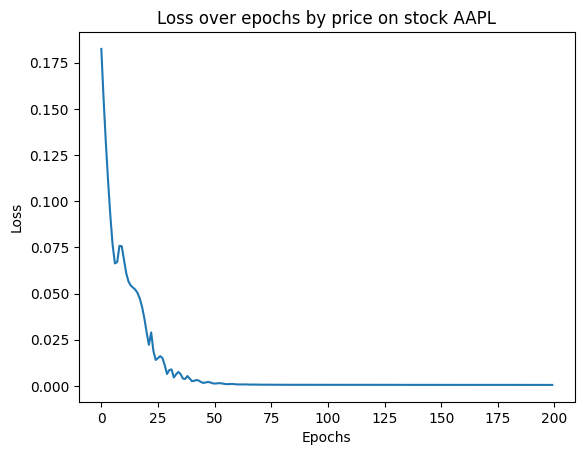

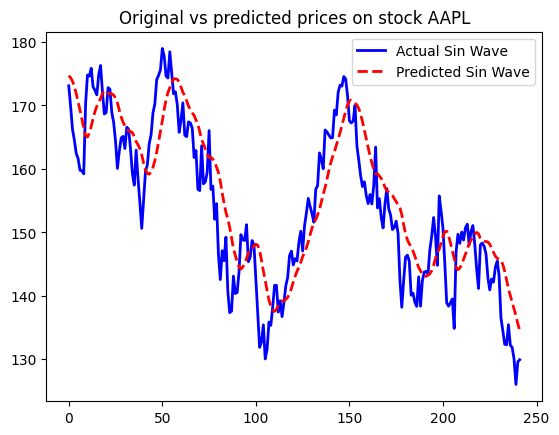

In [8]:
config = parse_config('config/config6.json', VALID_JSON)
learn(config)

Ticker : AAPL


[*********************100%***********************]  1 of 1 completed


Epoch [0/200] finished with loss: 0.23927707970142365
Epoch [20/200] finished with loss: 0.0179631095379591
Epoch [40/200] finished with loss: 0.001412153709679842
Epoch [60/200] finished with loss: 0.000535413040779531
Epoch [80/200] finished with loss: 0.0004615485086105764
Epoch [100/200] finished with loss: 0.0004429630353115499
Epoch [120/200] finished with loss: 0.00043555887532420456
Epoch [140/200] finished with loss: 0.0004293304809834808
Epoch [160/200] finished with loss: 0.0004231470520608127
Epoch [180/200] finished with loss: 0.00041681554284878075


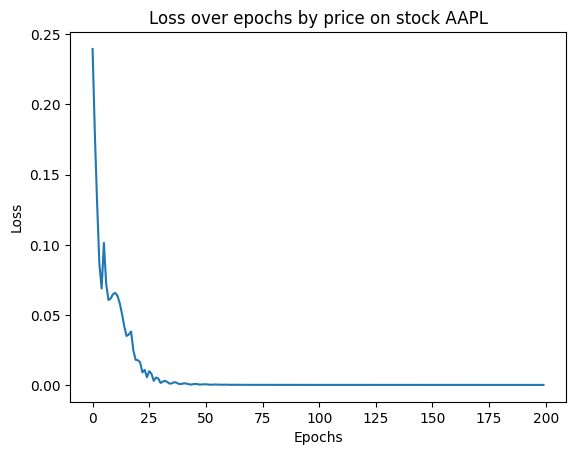

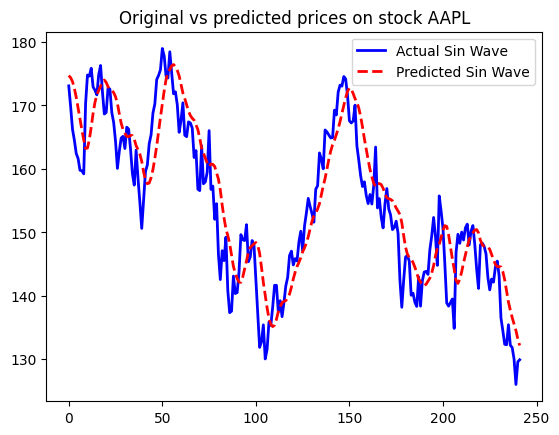

In [9]:
config = parse_config('config/config7.json', VALID_JSON)
learn(config)

[*********************100%***********************]  1 of 1 completed

Ticker : AAPL


Epoch [0/200] finished with loss: 0.16594557464122772
Epoch [20/200] finished with loss: 0.028215164318680763
Epoch [40/200] finished with loss: 0.002092523965984583
Epoch [60/200] finished with loss: 0.0008977437391877174
Epoch [80/200] finished with loss: 0.0006096435245126486
Epoch [100/200] finished with loss: 0.0005712303100153804
Epoch [120/200] finished with loss: 0.0005610942607745528
Epoch [140/200] finished with loss: 0.000550662400200963
Epoch [160/200] finished with loss: 0.0005405177944339812
Epoch [180/200] finished with loss: 0.0005303408834151924


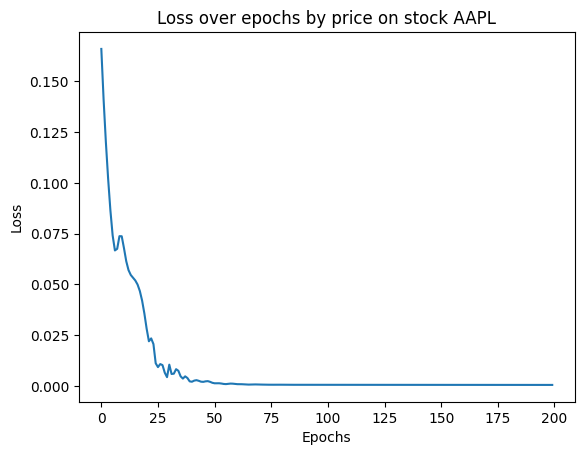

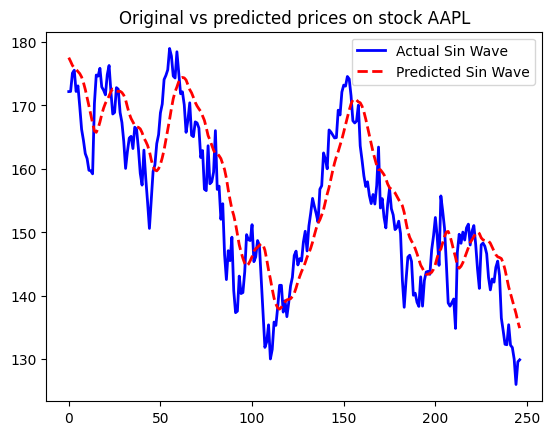

In [10]:
config = parse_config('config/config8.json', VALID_JSON)
learn(config)

[*********************100%***********************]  1 of 1 completed

Ticker : AAPL


Epoch [0/200] finished with loss: 0.20511408150196075
Epoch [20/200] finished with loss: 0.07563063502311707
Epoch [40/200] finished with loss: 0.01184994075447321
Epoch [60/200] finished with loss: 0.005513207521289587
Epoch [80/200] finished with loss: 0.001823608996346593
Epoch [100/200] finished with loss: 0.0013347893254831433
Epoch [120/200] finished with loss: 0.0011066508013755083
Epoch [140/200] finished with loss: 0.0009867458138614893
Epoch [160/200] finished with loss: 0.0008872478501871228
Epoch [180/200] finished with loss: 0.000811190577223897


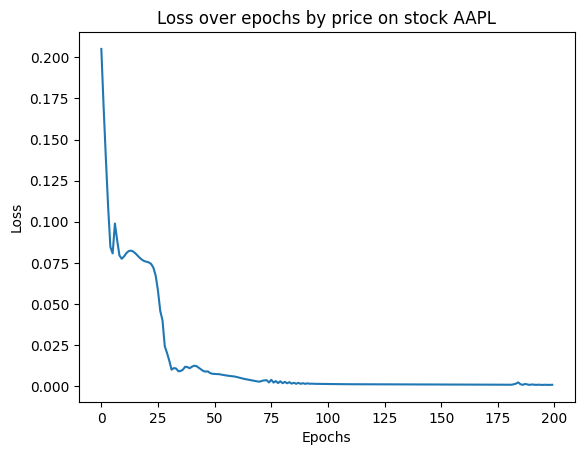

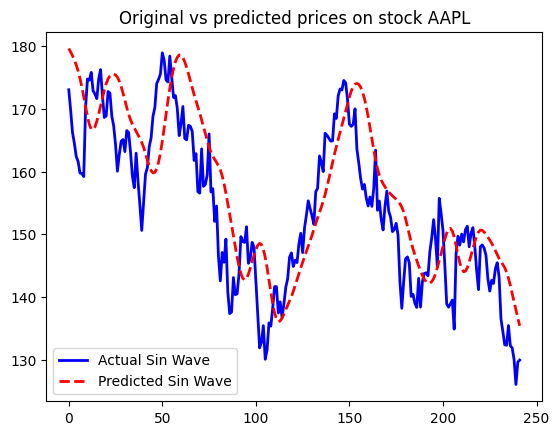

In [11]:
config = parse_config('config/config9.json', VALID_JSON)
learn(config)